In [24]:
%matplotlib notebook
from casadi import *
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def discretize(n):
    return [2*pi*k/n for k in range(n+1)]

In [3]:
def get_Ak(ex,ey,phi_k):
    return (ex*sin(phi_k)) - (ey*cos(phi_k))

In [4]:
def get_Bk(ex,ey,phi_k):
    return 1 + (ex*cos(phi_k)) + (ey*sin(phi_k))
    

In [5]:
def get_Ck(h,hx,hy,ex,ey,phi_k,m,mu):
    c11 = 0
    c12 = h**2/(mu*m*get_Bk(ex,ey,phi_k))
    c13 = 0
    
    c21 = 0
    c22 = h*hx/(mu*m*get_Bk(ex,ey,phi_k))
    c23 = (((h**2 * sqrt(h**2 - hx**2 - hy**2))/(mu*m*get_Bk(ex,ey,phi_k)*sqrt(h**2 - hy**2)))*sin(phi_k))
    c23 += (((h*hx*hy)/(mu*m*get_Bk(ex,ey,phi_k)*sqrt(h**2-hy**2)))*cos(phi_k))
    
    c31 = 0
    c32 = h*hy/(mu*m*get_Bk(ex,ey,phi_k))
    c33 = -h*sqrt(h**2-hy**2)*cos(phi_k)/(mu*m*get_Bk(ex,ey,phi_k))
    
    c41 = h*sin(phi_k)/(mu*m)
    c42 = (2*h*cos(phi_k)/(mu*m)) + (h*get_Ak(ex,ey,phi_k)*sin(phi_k)/(mu*m*get_Bk(ex,ey,phi_k)))
    c43 = h*ey*hy*sin(phi_k)/(mu*m*get_Bk(ex,ey,phi_k)*sqrt(h**2-hy**2))
    
    c51 = -h*cos(phi_k)/(mu*m)
    c52 = (2*h*sin(phi_k)/(mu*m))-(h*get_Ak(ex,ey,phi_k)*cos(phi_k)/(mu*m*get_Bk(ex,ey,phi_k)))
    c53 = -h*ex*hy*sin(phi_k)/(mu*m*get_Bk(ex,ey,phi_k)*sqrt(h**2-hy**2))
    
    C = np.array([[c11,c12,c13],[c21,c22,c23],[c31,c32,c33],[c41,c42,c43],[c51,c52,c53]])
    
    return C

In [6]:
def solve_orbit(W,X,Xd,n,m,mu,Fk):
    """
    Args: 
    - W, square diagonal matrix for weighting cost function
    - X, state vector for current revolution
    - Xd, desired state vector
    - n, number of control intervals (linear spacing for now)
    - m, mass of spacecraft at beginning of revolution (kg)
    - mu, gravitational constant
    - Fk, thrust magnitude
    
    Returns:
    - out, dict of outputs
        - Xnew, state at end of orbit
        - alpha, in plane thrust angles at control nodes
        - beta, out of plane thrust angles at control nodes
        
    """
    
    # define decision variables
    alpha = MX.sym('alpha',1,n)
    beta = MX.sym('beta',1,n)
    
    # convert thrust angles to thrust force components
    Fr = Fk * sin(alpha) * cos(beta)
    Fn = Fk * cos(alpha) * cos(beta)
    Fh = Fk * sin(beta)
    F = vertcat(Fr,Fn,Fh)
    
    # calculate discretization 
    phi = discretize(n)
    Ck = [0]*(n+1)
    Bk = [0]*(n+1)
    for k,phi_k in enumerate(phi):
        Ck[k] = get_Ck(h,hx,hy,ex,ey,phi_k,m,mu)
        Bk[k] = get_Bk(ex,ey,phi_k)

    # calculate linearized change in state due to thrust force
    dX = 0
    for k in range(n):
        p1 = h**3/((mu**2) * (Bk[k]**2))
        p2 = h**3/((mu**2) * (Bk[k+1]**2))
        p3 = h**7 * hy * sin(phi[k]) / (m * (mu**5) * sqrt(h**2 - hy**2) * (Bk[k]**5))
        p4 = h**7 * hy * sin(phi[k+1]) / (m * (mu**5) * sqrt(h**2 - hy**2) * (Bk[k+1]**5))

        p5 = (p1*Ck[k]@F[:,k]) + (p3*Ck[k]@vertcat(Fr[k]*Fh[k],Fn[k]*Fh[k],Fh[k]**2))
        p6 = (p2*Ck[k+1]@F[:,k]) + (p4*Ck[k+1]@vertcat(Fr[k]*Fh[k],Fn[k]*Fh[k],Fh[k]**2))

        dX += ((pi/n)*(p5+p6))

    # calculate terminal state
    Xend = X + dX
    
    # define cost function to minimize
    J = (Xd-Xend).T @ W @ (Xd-Xend)
    
    # initial guess for thrust angles is zero (straight out the back baby)
    x0 = [0]*2*n
    
    # bounds for thrust angles (-180 degrees to 180 degrees)
    lbx = [-pi]*2*n
    ubx = [pi]*2*n
    
    # solve nonlinear programming problem
    nlp = {'x':horzcat(alpha,beta), 'f':J, 'g':0}
    opts = {}
    opts['ipopt.print_level'] = 0
    opts['print_time'] = 0
    S = nlpsol('S', 'ipopt', nlp, opts)
    result = S(x0=x0,lbx=lbx,ubx=ubx)
    
    # getting optimal thrust angles
    alpha_opt = result['x'][0:n]
    beta_opt = result['x'][n:2*n]
    
    # calculating optimal thrust force
    Fr_opt = Fk * sin(alpha_opt) * cos(beta_opt)
    Fn_opt = Fk * cos(alpha_opt) * cos(beta_opt)
    Fh_opt = Fk * sin(beta_opt)
    
    # calculating optimal linearized change in state due to optimal thrust force
    dX_opt = 0
    for k in range(n):
        p1 = h**3/((mu**2) * (Bk[k]**2))
        p2 = h**3/((mu**2) * (Bk[k+1]**2))
        p3 = h**7 * hy * sin(phi[k]) / (m * (mu**5) * sqrt(h**2 - hy**2) * (Bk[k]**5))
        p4 = h**7 * hy * sin(phi[k+1]) / (m * (mu**5) * sqrt(h**2 - hy**2) * (Bk[k+1]**5))
        
        F_opt = vertcat(Fr_opt[k],Fn_opt[k],Fh_opt[k])
        
        p5 = (p1*Ck[k]@F_opt) + (p3*Ck[k]@vertcat(Fr_opt[k]*Fh_opt[k],Fn_opt[k]*Fh_opt[k],Fh_opt[k]**2))
        p6 = (p2*Ck[k+1]@F_opt) + (p4*Ck[k+1]@vertcat(Fr_opt[k]*Fh_opt[k],Fn_opt[k]*Fh_opt[k],Fh_opt[k]**2))

        dX_opt += ((pi/n)*(p5+p6))

    # calculating state for next revoltion 
    Xnew = X + dX_opt 
    
    # ouput
    out = {}
    out['alpha'] = alpha_opt.full()
    out['beta'] = beta_opt.full()
    out['Xnew'] = Xnew.full()
    return out

In [7]:
def solve_transfer(W,Xi,Xd,n,m,mu,Fk,tols,max_rev):
    Xs = []
    Xs.append(Xi.reshape((5,1)))
    alphas = []
    betas = []
    ageo = 1
    
    for i in range(max_rev):
        
        Xprev = Xs[-1]
        d = solve_orbit(W,Xprev,Xd,n,m,mu,Fk)
        
        Xnew = d['Xnew']
        
        Xs.append(Xnew)
        alphas.append(d['alpha'])
        betas.append(d['beta'])
        h_new = Xnew[0]
        hx_new = Xnew[1]
        hy_new = Xnew[2]
        ex_new = Xnew[3]
        ey_new = Xnew[4]
        
        print('ORBIT REV : ' + str(i) + ' | ' + 'h = ' + str(h_new) + ' | ' + 'hx = ' + str(hx_new) + ' | ' + 'hy = ' + str(hy_new) + ' | ' + 'ex = ' + str(ex_new) + ' | ' + 'ey = ' + str(ey_new) + ' | ')
        
        e_con = sqrt(ex_new**2 + ey_new**2) <= tols['e'] and sqrt(ex_new**2 + ey_new**2) >= 0
        a_con = h_new**2/(mu*(1-ex_new**2-ey_new**2)) >= ageo-tols['a'] and h_new**2/(mu*(1-ex_new**2-ey_new**2)) <= ageo+tols['a']
        i_con = sqrt((hx_new**2+hy_new**2)/(h_new)) >= 0 and sqrt((hx_new**2+hy_new**2)/(h_new)) <= sin(tols['i'])    
        
        if e_con and a_con and i_con:
            break
           
    out = {'X':Xs, 'alpha':alphas, 'beta':betas}
    return out

In [8]:
def ROR(phi):
    return np.array([[cos(phi),-sin(phi),0],[sin(phi),cos(phi),0],[0,0,1]])

def ROI(h,hx,hy):
    hz = sqrt(h**2 - hx**2 - hy**2)
    r11 = hz/sqrt(h**2-hy**2)
    r12 = -hx*hy/(h*sqrt(h**2-hy**2))
    r13 = hx/h
    r21 = 0
    r22 = (h**2-hy**2)/(h*sqrt(h**2-hy**2))
    r23 = hy/h
    r31 = -hx/sqrt(h**2-hy**2)
    r32 = -hy*hz/(h*sqrt(h**2-hy**2))
    r33 = hz/h
    return np.array([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]])


def xyz_position(h,hx,hy,ex,ey,phi,mu):
    r = h**2/(mu*(1+(ex*cos(phi))+(ey*sin(phi))))
    ror = ROR(phi)
    roi = ROI(h,hx,hy)
    return roi @ ror @ np.array([[r],[0],[0]])


def OE_to_X():
    pass



In [9]:
def plot_transfer(orbits,mu,s = 100):
    phi = discretize(s-1)
    fig = plt.figure()
    ax = fig.gca(projection='3d') 
    
    for i,orbit in enumerate(orbits):    
        h = orbit[0]
        hx = orbit[1]
        hy = orbit[2]
        ex = orbit[3]
        ey = orbit[4]

        x = np.zeros((s,))
        y = np.zeros((s,))
        z = np.zeros((s,))
        
        for k,phi_k in enumerate(phi): 
            xyz = xyz_position(h,hx,hy,ex,ey,phi_k,mu)
            x[k] = xyz[0]
            y[k] = xyz[1]
            z[k] = xyz[2]
        
        if i == 0:
            ax.plot(x, y, z, color='blue', label='Initial Orbit',linewidth=3.0)
        elif i == len(orbits)-1:
            ax.plot(x, y, z, color='red', label='Final Orbit',linewidth=3.0)
        else:
            ax.plot(x, y, z, linewidth=0.5, color=[0.5*(i/len(orbits)),0.1,0.5*(1-(i/len(orbits)))])

    leg = plt.legend()
    plt.show()

ORBIT REV : 0 | h = [0.90433991] | hx = [0.29806047] | hy = [-4.2881043e-19] | ex = [0.18149383] | ey = [6.66055888e-17] | 
ORBIT REV : 1 | h = [0.90864659] | hx = [0.29587841] | hy = [-2.95614499e-19] | ex = [0.16324268] | ey = [-1.35589223e-16] | 
ORBIT REV : 2 | h = [0.91291194] | hx = [0.29342759] | hy = [1.22228972e-17] | ex = [0.14530256] | ey = [-5.16485116e-15] | 
ORBIT REV : 3 | h = [0.91712619] | hx = [0.29067995] | hy = [2.71778932e-12] | ex = [0.12774436] | ey = [-9.71330241e-10] | 
ORBIT REV : 4 | h = [0.9212759] | hx = [0.28760551] | hy = [5.53421516e-12] | ex = [0.11065773] | ey = [-9.29927041e-10] | 
ORBIT REV : 5 | h = [0.92534406] | hx = [0.28417434] | hy = [8.62386722e-12] | ex = [0.09415573] | ey = [-8.8615892e-10] | 
ORBIT REV : 6 | h = [0.92930878] | hx = [0.28035838] | hy = [1.22323721e-11] | ex = [0.0783801] | ey = [-8.46283882e-10] | 
ORBIT REV : 7 | h = [0.93314237] | hx = [0.27613455] | hy = [3.05980801e-08] | ex = [0.06350626] | ey = [-1.00130987e-09] | 
ORB

<IPython.core.display.Javascript object>


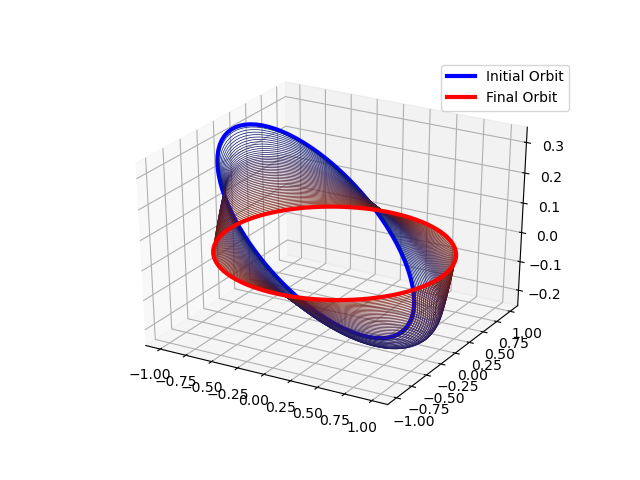

In [18]:
wh = 0.8
whx = 0.4
why = 0.4
wex = 0.6
wey = 0.2

W = np.array([[wh,0,0,0,0],[0,whx,0,0,0],[0,0,why,0,0],[0,0,0,wex,0],[0,0,0,0,wey]])

h = 0.9
hx = 0.3
hy = 0
ex = 0.2
ey = 0
X = np.array([h,hx,hy,ex,ey]).T

hd = 1
hxd = 0
hyd = 0
exd = 0
eyd = 0
Xd = np.array([hd,hxd,hyd,exd,eyd]).T

m = 1
mu = 1
n = 90
Fk = 0.003

tols = {'e':0.01, 'a':0.1, 'i':0.01}
max_rev = 300

transfer_data = solve_transfer(W,X,Xd,n,m,mu,Fk,tols,max_rev)
orbits = transfer_data['X']
alphas = transfer_data['alpha']
betas = transfer_data['beta']
plot_transfer(orbits,mu)




<IPython.core.display.Javascript object>


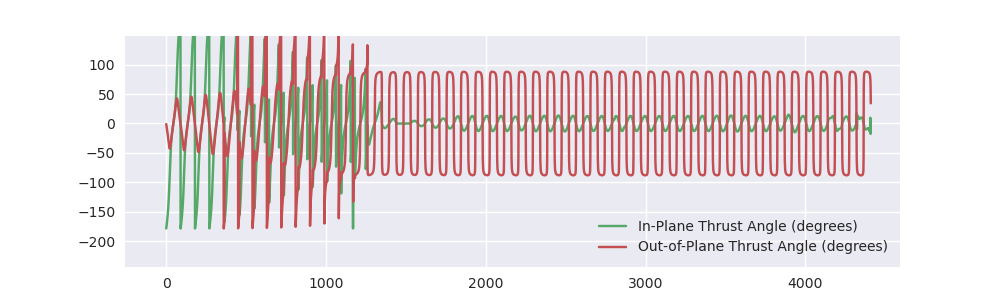

In [26]:
fig, ax = plt.subplots(figsize=(10, 3))
mpl.style.use('seaborn')
ax.plot(np.concatenate(np.concatenate(alphas))*180/pi, 'C1' , label='In-Plane Thrust Angle (degrees)')
ax.plot(np.concatenate(np.concatenate(betas))*180/pi, 'C2' , label='Out-of-Plane Thrust Angle (degrees)')
ax.legend()
plt.show()
